# A Criticism of the Paper [On Buggy Resizing Libraries](https://arxiv.org/abs/2104.11222)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch

from PIL import Image, ImageDraw
from torch.nn import functional as F

In [2]:
# create original image
size_1 = 128 # initial size
size_2 = 16 # downsampled size
radius = 50  # pixels in initial size

c0 = size_1 // 2 - radius  # xmin, ymin coordinate
c1 = size_1 // 2 + radius  # xmax, ymax coordinate

original_image = Image.new("RGB", (size_1, size_1), (255, 255, 255))
draw = ImageDraw.Draw(original_image)
draw.ellipse(((c0, c0), (c1, c1)), outline=(0, 0, 0), width=1)

In [3]:
# create framework-specific images
numpy_array = np.array(original_image)
pil_image = original_image
opencv_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)
tf_image = tf.constant(numpy_array)
pytorch_image = torch.tensor(numpy_array).permute(2, 0, 1).unsqueeze(0).float()

In [4]:
# "buggy" downsampling (bilinear interpolation without antialiasing)
buggy_pil_image = pil_image.resize((size_2, size_2), resample=Image.BILINEAR)
buggy_opencv_image = cv2.resize(
    opencv_image, (size_2, size_2), interpolation=cv2.INTER_LINEAR
)
buggy_tf_image = tf.image.resize(tf_image, (size_2, size_2), method="bilinear")
buggy_pytorch_image = F.interpolate(pytorch_image, size_2, mode="bilinear", align_corners=False)

In [5]:
# correct downsampling (antialiasing on)
correct_pil_image = pil_image.resize((size_2, size_2), resample=Image.BILINEAR)
correct_opencv_image = cv2.resize(
    opencv_image, (size_2, size_2), interpolation=cv2.INTER_AREA
)
correct_tf_image = tf.image.resize(
    tf_image, (size_2, size_2), method="bilinear", antialias=True
)
correct_pytorch_image = F.interpolate(pytorch_image, size_2, mode="area")

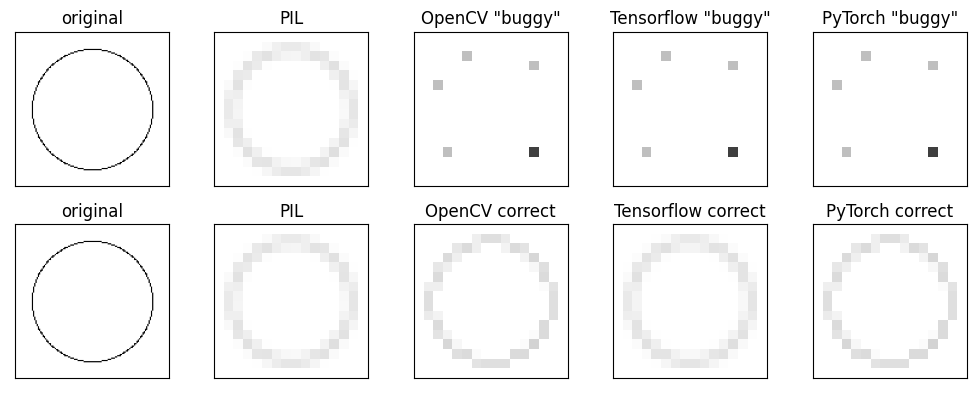

In [6]:
# plot images
images = [
    [
        original_image,
        buggy_pil_image,
        buggy_opencv_image,
        tf.cast(buggy_tf_image, tf.uint8),
        buggy_pytorch_image.byte().squeeze().permute(1, 2, 0),
    ],
    [
        original_image,
        correct_pil_image,
        correct_opencv_image,
        tf.cast(correct_tf_image, tf.uint8),
        correct_pytorch_image.byte().squeeze().permute(1, 2, 0),
    ],
]
titles = [
    ["original", "PIL", 'OpenCV "buggy"', 'Tensorflow "buggy"', 'PyTorch "buggy"'],
    ["original", "PIL", "OpenCV correct", "Tensorflow correct", "PyTorch correct"],
]
plt.figure(figsize=(5 * 2, 2 * 2), dpi=100, facecolor="white")
for row, (image_row, title_row) in enumerate(zip(images, titles)):
    for col, (image, title) in enumerate(zip(image_row, title_row)):
        plt.subplot(2, 5, row * 5 + col + 1)
        plt.imshow(image)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()